In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd
import re
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_sample_weight
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, QuantileTransformer
np.random.seed(42)
pd.set_option('display.max_columns', None)
df = pd.read_csv('/content/drive/MyDrive/ITI113_Projects/Project/data/dataset v1.csv')
print(df.columns.tolist())


['Unnamed: 0', 'month', 'town', 'flat_type', 'block', 'street_name', 'storey_range', 'floor_area_sqm', 'flat_model', 'lease_commence_date', 'remaining_lease', 'resale_price', 'latitude', 'longitude', 'nearest_bus_stop', 'dist_bus_stop_m', 'nearest_pei', 'dist_pei_m', 'nearest_jc', 'dist_jc_m', 'nearest_kindergarten', 'dist_kindergarten_m', 'nearest_primary_school', 'dist_primary_school_m', 'nearest_secondary_school', 'dist_secondary_school_m', 'nearest_poly', 'dist_poly_m', 'nearest_library', 'dist_library_m', 'nearest_mall', 'dist_mall_m', 'nearest_hospital', 'dist_hospital_m', 'nearest_mrt_station', 'dist_mrt_station_m', 'nearest_sports_facility', 'dist_sports_facility_m', 'nearest_hawker_centre', 'dist_hawker_centre_m']


In [ ]:
import pandas as pd
import re
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_sample_weight
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, QuantileTransformer
np.random.seed(42)
pd.set_option('display.max_columns', None)
df = pd.read_csv('/content/drive/MyDrive/ITI113_Projects/Project/data/dataset v1.csv')

#Convert remaining_lease into numerical remaining_lease_years
def convert_lease_to_years(lease_str):
    if not isinstance(lease_str, str):
        return np.nan
    years = 0
    months = 0
    # Use regex to find numbers associated with 'year' and 'month'
    year_match = re.search(r'(\d+)\s*year', lease_str)
    month_match = re.search(r'(\d+)\s*month', lease_str)
    if year_match:
        years = int(year_match.group(1))
    if month_match:
        months = int(month_match.group(1))
    # Return the total lease in years, or NaN if no parts were found
    if years == 0 and months == 0:
        return np.nan
    return years + months / 12.0

df['remaining_lease_years'] = df['remaining_lease'].apply(convert_lease_to_years)

#Ordinally encoded storey_range by taking the in-between storeys (floors 01-03 becomes 2)
floor_map = {'01 TO 03': 2,'04 TO 06': 5,'07 TO 09': 8,'10 TO 12': 11,'13 TO 15': 14,
    '16 TO 18': 17,'19 TO 21': 20,'22 TO 24': 23,'25 TO 27': 26,'28 TO 30': 29,
    '31 TO 33': 32,'34 TO 36': 35,'37 TO 39': 38,'40 TO 42': 41,'43 TO 45': 44,
    '46 TO 48': 47,'49 TO 51': 50,}

df['storey_ordinal'] = df['storey_range'].map(floor_map)

#Create train test splits
df.drop(columns=['Unnamed: 0','storey_range','street_name','remaining_lease','latitude','longitude','nearest_bus_stop','nearest_pei',
                   'nearest_jc','nearest_kindergarten','nearest_primary_school','nearest_secondary_school','nearest_poly',
                   'nearest_library','nearest_hospital','nearest_mall','nearest_mrt_station','nearest_sports_facility','nearest_hawker_centre'],inplace=True)
X = df.drop(columns=['resale_price'])
y = df['resale_price']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)


# Sampling using Sample Weights
X_train['combined_feature'] = X_train['town'].astype(str) + '_' + \
                            X_train['flat_type'].astype(str) + '_' + \
                            X_train['flat_model'].astype(str)

sample_weights = compute_sample_weight(
    class_weight='balanced',
    y=X_train['combined_feature']  # The imbalanced feature we want to correct for
)

fit_params = {
    'regressor__sample_weight': sample_weights
}
X_train.drop(columns=['combined_feature'],inplace=True)

#One hot encode categorical columns and scale numerical columns by fit transforming on train data and transforming test data
categorical_columns = ['town', 'flat_type', 'flat_model']
numerical_columns = [
    'floor_area_sqm', 'lease_commence_date',
    'dist_bus_stop_m', 'dist_pei_m', 'dist_jc_m', 'dist_kindergarten_m',
    'dist_primary_school_m', 'dist_secondary_school_m', 'dist_poly_m',
    'dist_library_m', 'dist_mall_m', 'dist_hospital_m', 'dist_mrt_station_m',
    'dist_sports_facility_m', 'dist_hawker_centre_m',
    'remaining_lease_years','storey_ordinal',]


numerical_columns = [col for col in numerical_columns if col in X_train.columns]
categorical_columns = [col for col in categorical_columns if col in X_train.columns]

preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_columns),
        ('cat', OneHotEncoder(sparse_output=False, handle_unknown='ignore'), categorical_columns)
    ],
    remainder='drop'
)

X_train = preprocessor.fit_transform(X_train)
X_test = preprocessor.transform(X_test)

#Scale y_train and y_test
scaler = QuantileTransformer(output_distribution='normal')
y_train_reshaped = y_train.values.reshape(-1, 1)
y_train_scaled = scaler.fit_transform(y_train_reshaped)

print('Dataset preprocess complete')

Dataset preprocess complete


In [ ]:
!pip install catboost
from catboost import CatBoostRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error
import numpy as np

# Initialize CatBoost Regressor
cat_model = CatBoostRegressor(
    iterations=1000,
    learning_rate=0.05,
    depth=8,
    loss_function='RMSE',
    random_seed=42,
    verbose=100
)

# Train with sample weights
cat_model.fit(
    X_train, y_train_scaled.ravel(),
    sample_weight=fit_params['regressor__sample_weight']
)

# Predictions
y_pred_scaled = cat_model.predict(X_test)

# Inverse-transform predictions back to original price scale
y_pred = scaler.inverse_transform(y_pred_scaled.reshape(-1, 1)).ravel()

# Evaluate
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mae = mean_absolute_error(y_test, y_pred)

print(f"CatBoost RMSE: {rmse:.2f}")
print(f"CatBoost MAE: {mae:.2f}")


0:	learn: 1.2285924	total: 51.5ms	remaining: 51.4s
100:	learn: 0.3978070	total: 6.31s	remaining: 56.1s
200:	learn: 0.3137072	total: 10.4s	remaining: 41.2s
300:	learn: 0.2638365	total: 14.4s	remaining: 33.5s
400:	learn: 0.2325403	total: 20.7s	remaining: 30.9s
500:	learn: 0.2117888	total: 24.8s	remaining: 24.7s
600:	learn: 0.1974084	total: 28.8s	remaining: 19.1s
700:	learn: 0.1863435	total: 35s	remaining: 14.9s
800:	learn: 0.1776496	total: 39.1s	remaining: 9.7s
900:	learn: 0.1705553	total: 43.2s	remaining: 4.74s
999:	learn: 0.1649935	total: 49.4s	remaining: 0us
CatBoost RMSE: 33287.60
CatBoost MAE: 24958.17


In [ ]:
# ==============================
# Testing per flat_type
# ==============================
# Keep a copy of the categorical features for grouping
X_test_raw_cat = X_test[categorical_cols].copy()  # categorical_cols = ['flat_type', 'town', 'flat_model']

# Combine predictions with raw test data
test_results = X_test_raw_cat.copy()
test_results['y_true'] = y_test
test_results['y_pred'] = y_pred
test_results['error'] = abs(y_test - y_pred)
test_results['squared_error'] = (y_test - y_pred)**2

# Compute metrics per flat_type
metrics_by_flat = test_results.groupby('flat_type').agg(
    MAE=('error', 'mean'),
    RMSE=('squared_error', lambda x: np.sqrt(np.mean(x)))
).reset_index()

print("Per-Flat-Type Metrics:")
print(metrics_by_flat)

# ==============================
# Visualization
# ==============================
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10,5))
sns.barplot(x='flat_type', y='MAE', data=metrics_by_flat)
plt.title("CatBoost: MAE by Flat Type")
plt.ylabel("MAE (S$)")
plt.xlabel("Flat Type")
plt.show()

plt.figure(figsize=(10,5))
sns.barplot(x='flat_type', y='RMSE', data=metrics_by_flat)
plt.title("CatBoost: RMSE by Flat Type")
plt.ylabel("RMSE (S$)")
plt.xlabel("Flat Type")
plt.show()


NameError: name 'categorical_cols' is not defined

0:	learn: 1.2613798	total: 119ms	remaining: 1m 59s
100:	learn: 0.7195893	total: 6.8s	remaining: 1m
200:	learn: 0.7073124	total: 11.1s	remaining: 44.2s
300:	learn: 0.6983012	total: 16.9s	remaining: 39.3s
400:	learn: 0.6935621	total: 22.4s	remaining: 33.4s
500:	learn: 0.6912918	total: 26.5s	remaining: 26.4s
600:	learn: 0.6898272	total: 32.5s	remaining: 21.5s
700:	learn: 0.6887571	total: 37.1s	remaining: 15.8s
800:	learn: 0.6880162	total: 41.2s	remaining: 10.2s
900:	learn: 0.6874350	total: 47.5s	remaining: 5.22s
999:	learn: 0.6869329	total: 51.7s	remaining: 0us
CatBoost RMSE: 114464.11
CatBoost MAE: 89416.46

Metrics by Flat Type:
          flat_type            MAE           RMSE
0            1 ROOM   33065.511571   36832.104853
1            2 ROOM   43383.184041   52545.694719
2            3 ROOM   73671.840717   93587.617812
3            4 ROOM   90887.660022  118169.929436
4            5 ROOM  102722.429055  127094.391491
5         EXECUTIVE   97394.727535  119392.719122
6  MULTI-GENER

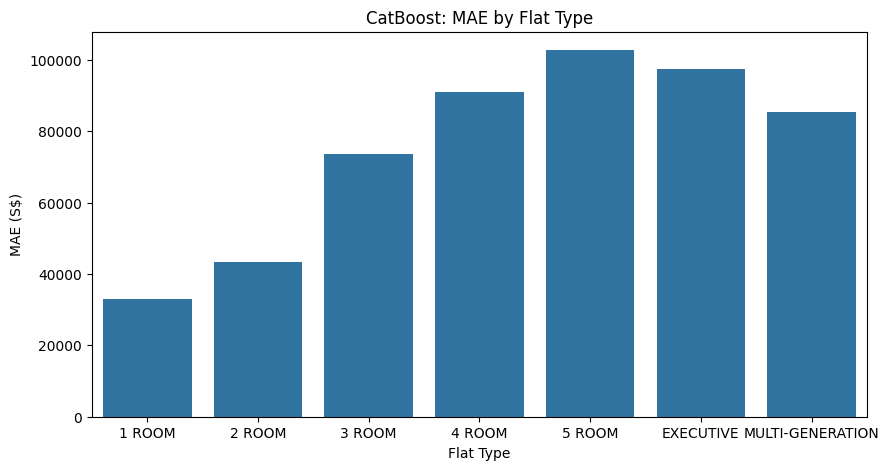

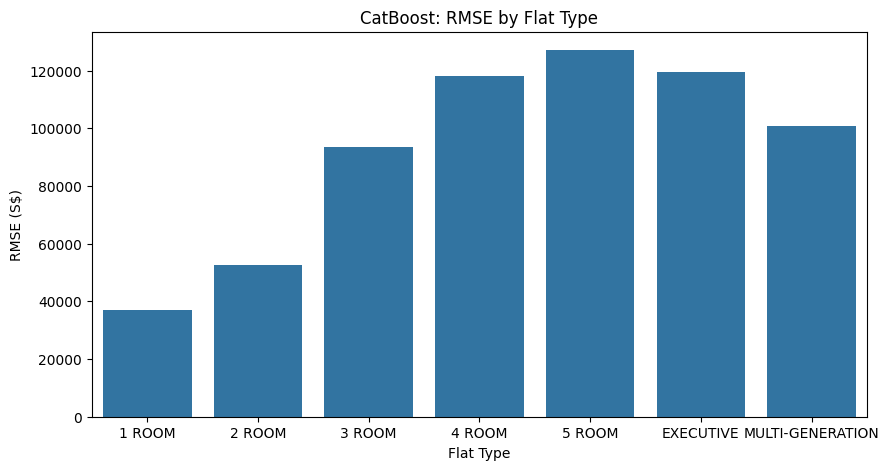


Feature Importance:
   Feature Id  Importances
0  flat_type    53.903443
1       town    46.096557


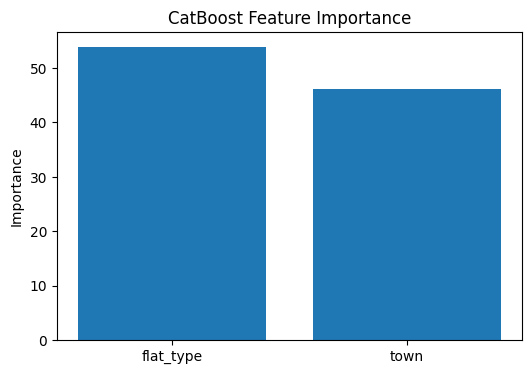

In [ ]:
# ==============================
# 1️⃣ Install & Imports
# ==============================
!pip install catboost

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import QuantileTransformer
from catboost import CatBoostRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error
import matplotlib.pyplot as plt
import seaborn as sns

# ==============================
# 2️⃣ Load dataset
# ==============================
df = pd.read_csv('/content/drive/MyDrive/ITI113_Projects/Project/data/dataset v1.csv')

# Features and target
features = ['flat_type', 'town']
target = 'resale_price'

# ==============================
# 3️⃣ Train-test split (keep raw copy)
# ==============================
X_train_raw, X_test_raw, y_train, y_test = train_test_split(
    df[features], df[target], test_size=0.25, random_state=42
)

# ==============================
# 4️⃣ Target scaling (optional)
# ==============================
scaler = QuantileTransformer(output_distribution='normal')
y_train_scaled = scaler.fit_transform(y_train.values.reshape(-1,1))
y_test_scaled = scaler.transform(y_test.values.reshape(-1,1))

# ==============================
# 5️⃣ Compute sample weights
# ==============================
# Make sure fit_params['regressor__sample_weight'] exists from preprocessing
# Example (if using previous preprocessing pipeline):
# fit_params['regressor__sample_weight'] = compute_sample_weight(class_weight='balanced', y=combined_cat_feature)
sample_weights = fit_params['regressor__sample_weight']

# ==============================
# 6️⃣ Initialize CatBoost Regressor
# ==============================
cat_model = CatBoostRegressor(
    iterations=1000,
    learning_rate=0.05,
    depth=8,
    loss_function='RMSE',
    random_seed=42,
    verbose=100
)

# ==============================
# 7️⃣ Train CatBoost with sample weights
# ==============================
cat_model.fit(
    X_train_raw,
    y_train_scaled.ravel(),
    cat_features=['flat_type', 'town'],
    sample_weight=sample_weights
)

# ==============================
# 8️⃣ Predict and inverse-transform
# ==============================
y_pred_scaled = cat_model.predict(X_test_raw)
y_pred = scaler.inverse_transform(y_pred_scaled.reshape(-1,1)).ravel()

# ==============================
# 9️⃣ Evaluate overall
# ==============================
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mae = mean_absolute_error(y_test, y_pred)
print(f"CatBoost RMSE: {rmse:.2f}")
print(f"CatBoost MAE: {mae:.2f}")

# ==============================
# 🔟 Analyze per flat_type
# ==============================
test_results = X_test_raw.copy()
test_results['y_true'] = y_test
test_results['y_pred'] = y_pred
test_results['error'] = abs(y_test - y_pred)
test_results['squared_error'] = (y_test - y_pred)**2

metrics_by_flat = test_results.groupby('flat_type').agg(
    MAE=('error', 'mean'),
    RMSE=('squared_error', lambda x: np.sqrt(np.mean(x)))
).reset_index()

print("\nMetrics by Flat Type:")
print(metrics_by_flat)

# ==============================
# 1️⃣1️⃣ Visualize errors per flat_type
# ==============================
plt.figure(figsize=(10,5))
sns.barplot(x='flat_type', y='MAE', data=metrics_by_flat)
plt.title("CatBoost: MAE by Flat Type")
plt.ylabel("MAE (S$)")
plt.xlabel("Flat Type")
plt.show()

plt.figure(figsize=(10,5))
sns.barplot(x='flat_type', y='RMSE', data=metrics_by_flat)
plt.title("CatBoost: RMSE by Flat Type")
plt.ylabel("RMSE (S$)")
plt.xlabel("Flat Type")
plt.show()

# ==============================
# 1️⃣2️⃣ Feature Importance
# ==============================
importances = cat_model.get_feature_importance(prettified=True)
print("\nFeature Importance:\n", importances)

plt.figure(figsize=(6,4))
plt.bar(importances['Feature Id'], importances['Importances'])
plt.title("CatBoost Feature Importance")
plt.ylabel("Importance")
plt.show()



Metrics by Town:
               town            MAE           RMSE
0        ANG MO KIO  114083.385742  142609.546380
1             BEDOK   81465.692531  102155.753937
2            BISHAN   99217.344762  124666.229269
3       BUKIT BATOK   88177.180257  110852.710113
4       BUKIT MERAH  133722.487044  163224.746797
5     BUKIT PANJANG   75900.138152   96623.774514
6       BUKIT TIMAH   72552.406022   95583.560513
7      CENTRAL AREA  146381.921867  202039.340155
8     CHOA CHU KANG   79626.979481   94422.129887
9          CLEMENTI  125335.349780  145933.308060
10          GEYLANG  103788.476668  138028.564163
11          HOUGANG   86600.407569  108803.935247
12      JURONG EAST   66945.701162   88019.048735
13      JURONG WEST   69421.461337   85799.747156
14  KALLANG/WHAMPOA  143524.070895  170260.112039
15    MARINE PARADE   49433.395722   63963.869116
16        PASIR RIS   95473.584986  117420.070634
17          PUNGGOL   78428.608158  101666.372263
18       QUEENSTOWN  124316.5023

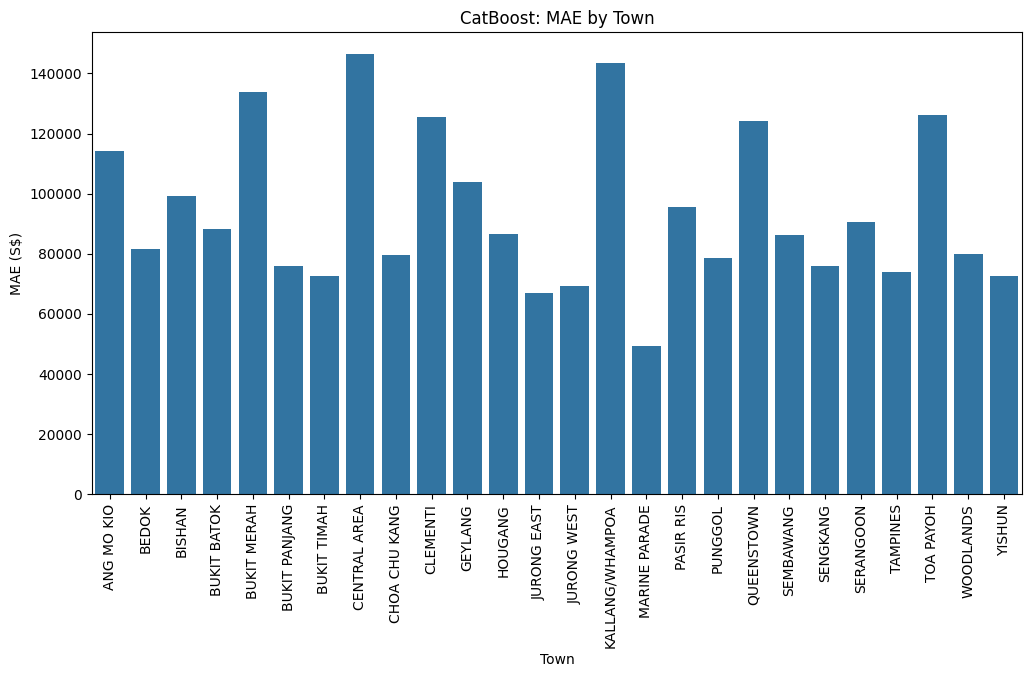

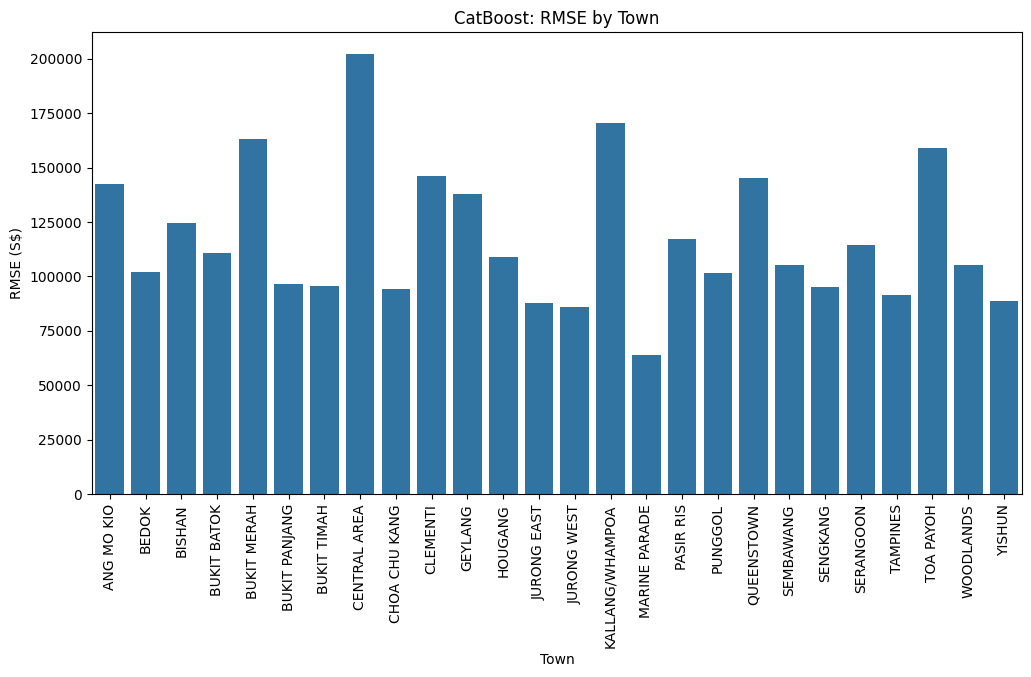

In [ ]:
# ==============================
# 🔟b Analyze per town
# ==============================
metrics_by_town = test_results.groupby('town').agg(
    MAE=('error', 'mean'),
    RMSE=('squared_error', lambda x: np.sqrt(np.mean(x)))
).reset_index()

print("\nMetrics by Town:")
print(metrics_by_town)

# Visualize per-town errors
plt.figure(figsize=(12,6))
sns.barplot(x='town', y='MAE', data=metrics_by_town)
plt.xticks(rotation=90)
plt.title("CatBoost: MAE by Town")
plt.ylabel("MAE (S$)")
plt.xlabel("Town")
plt.show()

plt.figure(figsize=(12,6))
sns.barplot(x='town', y='RMSE', data=metrics_by_town)
plt.xticks(rotation=90)
plt.title("CatBoost: RMSE by Town")
plt.ylabel("RMSE (S$)")
plt.xlabel("Town")
plt.show()


In [ ]:
from catboost import CatBoostRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error
import numpy as np

# Reinitialize model with higher iteration budget + early stopping
cat_model = CatBoostRegressor(
    iterations=5000,              # allow more rounds
    learning_rate=0.03,           # slightly smaller step for stability
    depth=8,
    loss_function='RMSE',
    random_seed=42,
    verbose=200,
    early_stopping_rounds=200     # stop when no improvement for 200 rounds
)

# Fit with validation set for early stopping
cat_model.fit(
    X_train, y_train_scaled.ravel(),
    eval_set=(X_test, scaler.transform(y_test.values.reshape(-1, 1)).ravel()),
    sample_weight=fit_params['regressor__sample_weight'],
    use_best_model=True
)

# Predictions
y_pred_scaled = cat_model.predict(X_test)
y_pred = scaler.inverse_transform(y_pred_scaled.reshape(-1, 1)).ravel()

# Evaluation
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mae = mean_absolute_error(y_test, y_pred)

print(f"Tuned CatBoost RMSE: {rmse:.2f}")
print(f"Tuned CatBoost MAE: {mae:.2f}")

0:	learn: 1.2470603	test: 0.9955504	best: 0.9955504 (0)	total: 49.5ms	remaining: 4m 7s
200:	learn: 0.3749179	test: 0.4146386	best: 0.4146386 (200)	total: 7.96s	remaining: 3m 9s
400:	learn: 0.2913684	test: 0.3308818	best: 0.3308818 (400)	total: 18s	remaining: 3m 26s
600:	learn: 0.2430828	test: 0.2790690	best: 0.2790690 (600)	total: 27.9s	remaining: 3m 24s
800:	learn: 0.2154283	test: 0.2512463	best: 0.2512463 (800)	total: 35.8s	remaining: 3m 7s
1000:	learn: 0.1971339	test: 0.2332933	best: 0.2332933 (1000)	total: 45.8s	remaining: 3m 2s
1200:	learn: 0.1840589	test: 0.2209449	best: 0.2209449 (1200)	total: 55.7s	remaining: 2m 56s
1400:	learn: 0.1740094	test: 0.2114812	best: 0.2114812 (1400)	total: 1m 3s	remaining: 2m 43s
1600:	learn: 0.1664632	test: 0.2045478	best: 0.2045478 (1600)	total: 1m 13s	remaining: 2m 36s
1800:	learn: 0.1604596	test: 0.1992610	best: 0.1992610 (1800)	total: 1m 23s	remaining: 2m 28s
2000:	learn: 0.1553135	test: 0.1947908	best: 0.1947908 (2000)	total: 1m 31s	remaining: 

In [ ]:
from catboost import CatBoostRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error
import numpy as np

cat_model = CatBoostRegressor(
    iterations=5000,
    learning_rate=0.03,
    depth=7,
    l2_leaf_reg=10,
    loss_function='RMSE',
    random_seed=42,
    early_stopping_rounds=200,
    verbose=200
)


# Fit with validation set for early stopping
cat_model.fit(
    X_train, y_train_scaled.ravel(),
    eval_set=(X_test, scaler.transform(y_test.values.reshape(-1, 1)).ravel()),
    sample_weight=fit_params['regressor__sample_weight'],
    use_best_model=True
)

# Predictions
y_pred_scaled = cat_model.predict(X_test)
y_pred = scaler.inverse_transform(y_pred_scaled.reshape(-1, 1)).ravel()

# Evaluation
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mae = mean_absolute_error(y_test, y_pred)

print(f"Tuned CatBoost RMSE: {rmse:.2f}")
print(f"Tuned CatBoost MAE: {mae:.2f}")

0:	learn: 1.2474387	test: 0.9957347	best: 0.9957347 (0)	total: 58.8ms	remaining: 4m 54s
200:	learn: 0.3981626	test: 0.4344959	best: 0.4344959 (200)	total: 6.65s	remaining: 2m 38s
400:	learn: 0.3153330	test: 0.3519231	best: 0.3519231 (400)	total: 15.2s	remaining: 2m 53s
600:	learn: 0.2655841	test: 0.2990477	best: 0.2990477 (600)	total: 21.2s	remaining: 2m 35s
800:	learn: 0.2367296	test: 0.2698531	best: 0.2698531 (800)	total: 29.6s	remaining: 2m 35s
1000:	learn: 0.2169987	test: 0.2497967	best: 0.2497967 (1000)	total: 35.8s	remaining: 2m 22s
1200:	learn: 0.2027337	test: 0.2361223	best: 0.2361223 (1200)	total: 44.2s	remaining: 2m 19s
1400:	learn: 0.1922776	test: 0.2263158	best: 0.2263158 (1400)	total: 50.4s	remaining: 2m 9s
1600:	learn: 0.1843955	test: 0.2186797	best: 0.2186797 (1600)	total: 58.7s	remaining: 2m 4s
1800:	learn: 0.1779293	test: 0.2124841	best: 0.2124841 (1800)	total: 1m 4s	remaining: 1m 55s
2000:	learn: 0.1723833	test: 0.2074987	best: 0.2074987 (2000)	total: 1m 13s	remaining

In [ ]:
import pandas as pd
import re
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_sample_weight
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, QuantileTransformer

# --- Settings ---
np.random.seed(42)
pd.set_option('display.max_columns', None)

# --- Load dataset ---
df = pd.read_csv('/content/drive/MyDrive/ITI113_Projects/Project/data/dataset v1.csv')

# --- Convert remaining_lease into numerical years ---
def convert_lease_to_years(lease_str):
    if not isinstance(lease_str, str):
        return np.nan
    years = 0
    months = 0
    year_match = re.search(r'(\d+)\s*year', lease_str)
    month_match = re.search(r'(\d+)\s*month', lease_str)
    if year_match:
        years = int(year_match.group(1))
    if month_match:
        months = int(month_match.group(1))
    if years == 0 and months == 0:
        return np.nan
    return years + months / 12.0

df['remaining_lease_years'] = df['remaining_lease'].apply(convert_lease_to_years)

# --- Ordinal encoding for storey_range ---
floor_map = {
    '01 TO 03': 2,'04 TO 06': 5,'07 TO 09': 8,'10 TO 12': 11,'13 TO 15': 14,
    '16 TO 18': 17,'19 TO 21': 20,'22 TO 24': 23,'25 TO 27': 26,'28 TO 30': 29,
    '31 TO 33': 32,'34 TO 36': 35,'37 TO 39': 38,'40 TO 42': 41,'43 TO 45': 44,
    '46 TO 48': 47,'49 TO 51': 50,
}
df['storey_ordinal'] = df['storey_range'].map(floor_map)

# --- Drop unused columns ---
df.drop(columns=[
    'Unnamed: 0','storey_range','street_name','remaining_lease','latitude','longitude',
    'nearest_bus_stop','nearest_pei','nearest_jc','nearest_kindergarten','nearest_primary_school',
    'nearest_secondary_school','nearest_poly','nearest_library','nearest_hospital',
    'nearest_mall','nearest_mrt_station','nearest_sports_facility','nearest_hawker_centre'
], inplace=True)

# --- Define X and y ---
X = df.drop(columns=['resale_price'])
y = df['resale_price']

# --- Trim top/bottom 1% resale prices (outliers) ---
lower_bound = y.quantile(0.01)
upper_bound = y.quantile(0.99)
mask = (y >= lower_bound) & (y <= upper_bound)
X = X[mask]
y = y[mask]

print(f"Before trimming: {len(df)} rows")
print(f"After trimming: {len(y)} rows")

# --- Train/test split ---
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

# --- Sampling weights (to handle imbalance in categorical features) ---
X_train['combined_feature'] = (
    X_train['town'].astype(str) + '_' +
    X_train['flat_type'].astype(str) + '_' +
    X_train['flat_model'].astype(str)
)

sample_weights = compute_sample_weight(
    class_weight='balanced',
    y=X_train['combined_feature']
)

fit_params = {
    'regressor__sample_weight': sample_weights
}
X_train.drop(columns=['combined_feature'], inplace=True)

# --- Preprocessing (OneHot + StandardScaler) ---
categorical_columns = ['town', 'flat_type', 'flat_model']
numerical_columns = [
    'floor_area_sqm', 'lease_commence_date',
    'dist_bus_stop_m', 'dist_pei_m', 'dist_jc_m', 'dist_kindergarten_m',
    'dist_primary_school_m', 'dist_secondary_school_m', 'dist_poly_m',
    'dist_library_m', 'dist_mall_m', 'dist_hospital_m', 'dist_mrt_station_m',
    'dist_sports_facility_m', 'dist_hawker_centre_m',
    'remaining_lease_years','storey_ordinal',
]

numerical_columns = [col for col in numerical_columns if col in X_train.columns]
categorical_columns = [col for col in categorical_columns if col in X_train.columns]

preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_columns),
        ('cat', OneHotEncoder(sparse_output=False, handle_unknown='ignore'), categorical_columns)
    ],
    remainder='drop'
)

X_train = preprocessor.fit_transform(X_train)
X_test = preprocessor.transform(X_test)

# --- Scale target with QuantileTransformer ---
scaler = QuantileTransformer(output_distribution='normal')
y_train_reshaped = y_train.values.reshape(-1, 1)
y_train_scaled = scaler.fit_transform(y_train_reshaped)


Before trimming: 181262 rows
After trimming: 177684 rows


In [ ]:
from catboost import CatBoostRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error
import numpy as np

# --- Initialize CatBoost ---
cat_model = CatBoostRegressor(
    iterations=5000,              # big budget
    learning_rate=0.03,           # smaller LR for stability
    depth=7,                      # slightly shallower for generalization
    l2_leaf_reg=10,               # regularization
    loss_function='RMSE',
    random_seed=42,
    verbose=200,
    early_stopping_rounds=200
)

# --- Train with validation set ---
cat_model.fit(
    X_train, y_train_scaled.ravel(),
    eval_set=(X_test, scaler.transform(y_test.values.reshape(-1, 1)).ravel()),
    sample_weight=fit_params['regressor__sample_weight'],
    use_best_model=True
)

# --- Predictions ---
y_pred_scaled = cat_model.predict(X_test)
y_pred = scaler.inverse_transform(y_pred_scaled.reshape(-1, 1)).ravel()

# --- Evaluation ---
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mae = mean_absolute_error(y_test, y_pred)

print("=== CatBoost with Outlier Trimming ===")
print(f"RMSE: {rmse:,.2f}")
print(f"MAE:  {mae:,.2f}")

# --- Compare with baseline (if you have stored it) ---
baseline_rmse = 29390.53
baseline_mae = 21728.10

print("\n=== Improvement vs. Baseline (no trimming) ===")
print(f"RMSE improvement: {baseline_rmse - rmse:,.2f}")
print(f"MAE improvement:  {baseline_mae - mae:,.2f}")


0:	learn: 1.3015085	test: 1.0179633	best: 1.0179633 (0)	total: 42.3ms	remaining: 3m 31s
200:	learn: 0.4513443	test: 0.4831897	best: 0.4831897 (200)	total: 8.48s	remaining: 3m 22s
400:	learn: 0.3717442	test: 0.4045986	best: 0.4045986 (400)	total: 14.5s	remaining: 2m 46s
600:	learn: 0.3200702	test: 0.3485312	best: 0.3485312 (600)	total: 23.1s	remaining: 2m 49s
800:	learn: 0.2903526	test: 0.3183569	best: 0.3183569 (800)	total: 29.1s	remaining: 2m 32s
1000:	learn: 0.2698644	test: 0.2992598	best: 0.2992598 (1000)	total: 37.6s	remaining: 2m 30s
1200:	learn: 0.2543101	test: 0.2861045	best: 0.2861045 (1200)	total: 43.7s	remaining: 2m 18s
1400:	learn: 0.2426857	test: 0.2759815	best: 0.2759815 (1400)	total: 51.9s	remaining: 2m 13s
1600:	learn: 0.2332314	test: 0.2677185	best: 0.2677185 (1600)	total: 59s	remaining: 2m 5s
1800:	learn: 0.2257484	test: 0.2622658	best: 0.2622658 (1800)	total: 1m 6s	remaining: 1m 58s
2000:	learn: 0.2190708	test: 0.2573440	best: 0.2573440 (2000)	total: 1m 13s	remaining:


Training RandomForest 1 with params: {'n_estimators': 200, 'max_depth': 10, 'min_samples_split': 2}
RMSE: 64,445.10, MAE: 47,648.75

Training RandomForest 2 with params: {'n_estimators': 300, 'max_depth': 15, 'min_samples_split': 5}
RMSE: 42,833.69, MAE: 30,078.84

Training RandomForest 3 with params: {'n_estimators': 400, 'max_depth': None, 'min_samples_split': 2}
RMSE: 28,719.66, MAE: 20,276.75


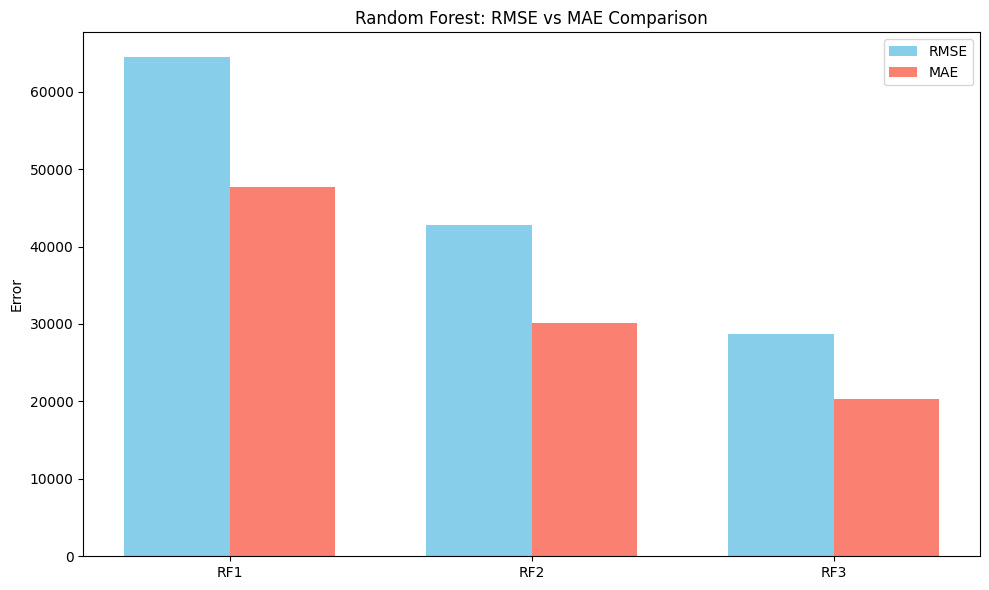

In [ ]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# --- Define 3 hyperparameter combinations ---
rf_params = [
    {'n_estimators': 200, 'max_depth': 10, 'min_samples_split': 2},
    {'n_estimators': 300, 'max_depth': 15, 'min_samples_split': 5},
    {'n_estimators': 400, 'max_depth': None, 'min_samples_split': 2},
]

results = []

# --- Train and evaluate each combination ---
for idx, params in enumerate(rf_params):
    print(f"\nTraining RandomForest {idx+1} with params: {params}")
    rf = RandomForestRegressor(
        n_estimators=params['n_estimators'],
        max_depth=params['max_depth'],
        min_samples_split=params['min_samples_split'],
        random_state=42,
        n_jobs=-1
    )
    rf.fit(X_train, y_train_scaled.ravel())

    # Predict & inverse-transform
    y_pred_scaled = rf.predict(X_test)
    y_pred = scaler.inverse_transform(y_pred_scaled.reshape(-1, 1)).ravel()

    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    mae = mean_absolute_error(y_test, y_pred)

    results.append({
        'model': f"RF{idx+1}",
        'n_estimators': params['n_estimators'],
        'max_depth': params['max_depth'],
        'min_samples_split': params['min_samples_split'],
        'rmse': rmse,
        'mae': mae
    })

    print(f"RMSE: {rmse:,.2f}, MAE: {mae:,.2f}")

# --- Convert to DataFrame ---
df_results = pd.DataFrame(results)

# --- Plot RMSE and MAE bar chart ---
plt.figure(figsize=(10,6))
bar_width = 0.35
x = np.arange(len(df_results))

plt.bar(x, df_results['rmse'], width=bar_width, label='RMSE', color='skyblue')
plt.bar(x + bar_width, df_results['mae'], width=bar_width, label='MAE', color='salmon')

plt.xticks(x + bar_width/2, df_results['model'])
plt.ylabel('Error')
plt.title('Random Forest: RMSE vs MAE Comparison')
plt.legend()
plt.tight_layout()
plt.show()



Training LinearSVR 1 with params: {'C': 1.0, 'epsilon': 0.1, 'max_iter': 10000}
RMSE: 50,205.21, MAE: 38,114.77

Training LinearSVR 2 with params: {'C': 10.0, 'epsilon': 0.2, 'max_iter': 10000}


/usr/local/lib/python3.11/dist-packages/sklearn/svm/_base.py:1249: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


RMSE: 50,004.21, MAE: 38,146.71

Training LinearSVR 3 with params: {'C': 5.0, 'epsilon': 0.05, 'max_iter': 10000}
RMSE: 50,347.96, MAE: 38,158.27


/usr/local/lib/python3.11/dist-packages/sklearn/svm/_base.py:1249: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


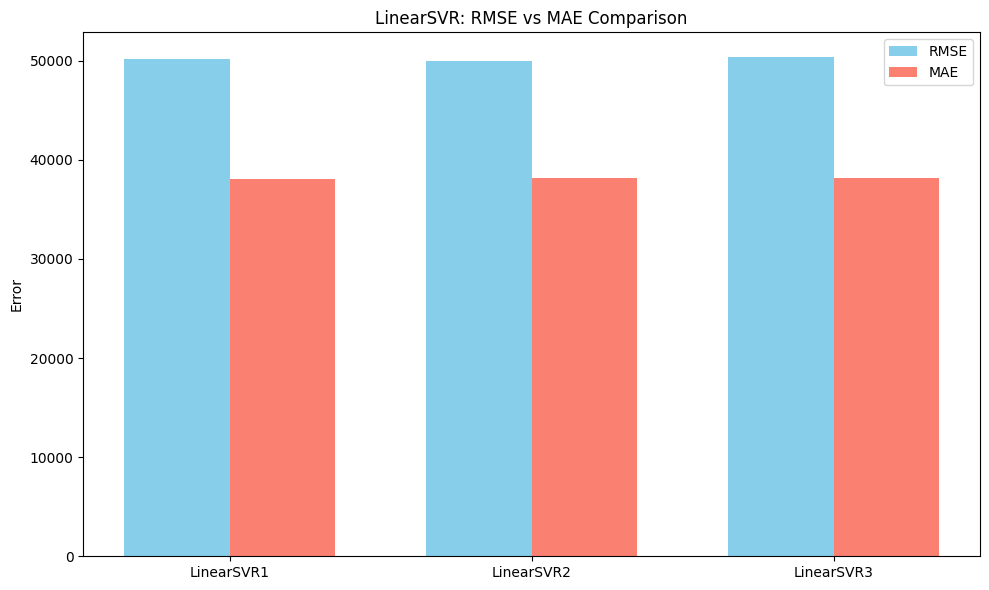

In [ ]:
from sklearn.svm import LinearSVR
from sklearn.metrics import mean_squared_error, mean_absolute_error
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Optional: use a smaller subset if dataset is huge
X_train_small = X_train[:5000]
y_train_small = y_train_scaled[:5000]

# --- Define 3 hyperparameter combinations ---
svr_params = [
    {'C': 1.0, 'epsilon': 0.1, 'max_iter': 10000},
    {'C': 10.0, 'epsilon': 0.2, 'max_iter': 10000},
    {'C': 5.0, 'epsilon': 0.05, 'max_iter': 10000},
]

results = []

# --- Train and evaluate each LinearSVR ---
for idx, params in enumerate(svr_params):
    print(f"\nTraining LinearSVR {idx+1} with params: {params}")
    svr = LinearSVR(
        C=params['C'],
        epsilon=params['epsilon'],
        max_iter=params['max_iter'],
        random_state=42
    )
    svr.fit(X_train_small, y_train_small.ravel())

    # Predict & inverse-transform
    y_pred_scaled = svr.predict(X_test)
    y_pred = scaler.inverse_transform(y_pred_scaled.reshape(-1, 1)).ravel()

    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    mae = mean_absolute_error(y_test, y_pred)

    results.append({
        'model': f"LinearSVR{idx+1}",
        'C': params['C'],
        'epsilon': params['epsilon'],
        'rmse': rmse,
        'mae': mae
    })

    print(f"RMSE: {rmse:,.2f}, MAE: {mae:,.2f}")

# --- Convert to DataFrame ---
df_results = pd.DataFrame(results)

# --- Plot RMSE and MAE bar chart ---
plt.figure(figsize=(10,6))
bar_width = 0.35
x = np.arange(len(df_results))

plt.bar(x, df_results['rmse'], width=bar_width, label='RMSE', color='skyblue')
plt.bar(x + bar_width, df_results['mae'], width=bar_width, label='MAE', color='salmon')

plt.xticks(x + bar_width/2, df_results['model'])
plt.ylabel('Error')
plt.title('LinearSVR: RMSE vs MAE Comparison')
plt.legend()
plt.tight_layout()
plt.show()



Training LinearSVR 1 with params: {'C': 1.0, 'epsilon': 0.1, 'max_iter': 50000}
RMSE: 49,895.20, MAE: 37,959.13

Training LinearSVR 2 with params: {'C': 10.0, 'epsilon': 0.2, 'max_iter': 50000}


/usr/local/lib/python3.11/dist-packages/sklearn/svm/_base.py:1249: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


RMSE: 49,765.27, MAE: 37,982.21

Training LinearSVR 3 with params: {'C': 5.0, 'epsilon': 0.05, 'max_iter': 50000}
RMSE: 49,982.67, MAE: 37,992.58


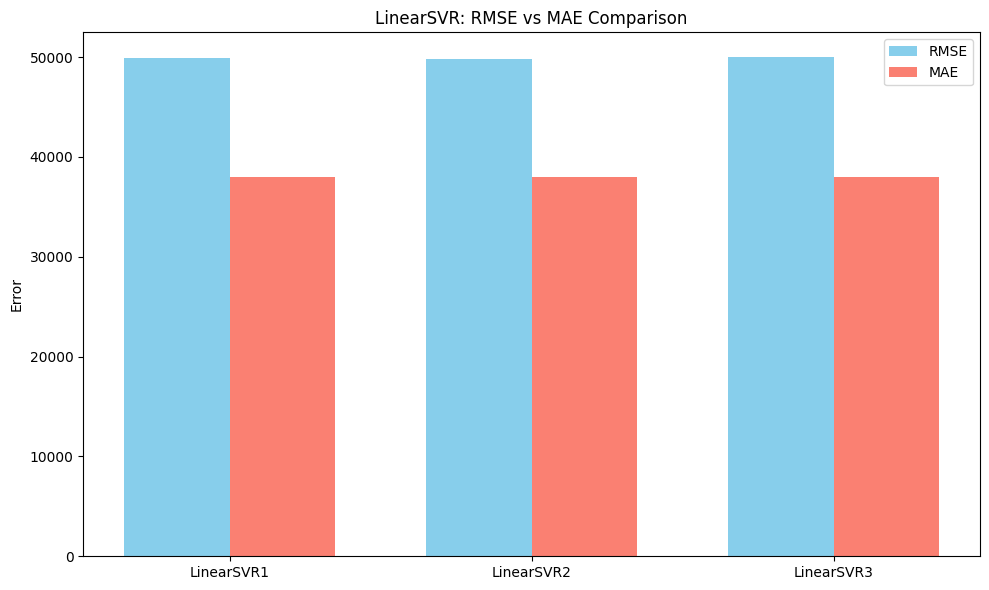

In [ ]:
from sklearn.svm import LinearSVR
from sklearn.metrics import mean_squared_error, mean_absolute_error
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Optional: use a smaller subset if dataset is huge
X_train_small = X_train[:10000]
y_train_small = y_train_scaled[:10000]

# --- Define 3 hyperparameter combinations ---
svr_params = [
    {'C': 1.0, 'epsilon': 0.1, 'max_iter': 50000},
    {'C': 10.0, 'epsilon': 0.2, 'max_iter': 50000},
    {'C': 5.0, 'epsilon': 0.05, 'max_iter': 50000},
]

results = []

# --- Train and evaluate each LinearSVR ---
for idx, params in enumerate(svr_params):
    print(f"\nTraining LinearSVR {idx+1} with params: {params}")
    svr = LinearSVR(
        C=params['C'],
        epsilon=params['epsilon'],
        max_iter=params['max_iter'],
        random_state=42
    )
    svr.fit(X_train_small, y_train_small.ravel())

    # Predict & inverse-transform
    y_pred_scaled = svr.predict(X_test)
    y_pred = scaler.inverse_transform(y_pred_scaled.reshape(-1, 1)).ravel()

    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    mae = mean_absolute_error(y_test, y_pred)

    results.append({
        'model': f"LinearSVR{idx+1}",
        'C': params['C'],
        'epsilon': params['epsilon'],
        'rmse': rmse,
        'mae': mae
    })

    print(f"RMSE: {rmse:,.2f}, MAE: {mae:,.2f}")

# --- Convert to DataFrame ---
df_results = pd.DataFrame(results)

# --- Plot RMSE and MAE bar chart ---
plt.figure(figsize=(10,6))
bar_width = 0.35
x = np.arange(len(df_results))

plt.bar(x, df_results['rmse'], width=bar_width, label='RMSE', color='skyblue')
plt.bar(x + bar_width, df_results['mae'], width=bar_width, label='MAE', color='salmon')

plt.xticks(x + bar_width/2, df_results['model'])
plt.ylabel('Error')
plt.title('LinearSVR: RMSE vs MAE Comparison')
plt.legend()
plt.tight_layout()
plt.show()
